In [1]:
import keras

/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras_contrib.applications.resnet import ResNet18
from keras.applications.vgg16 import VGG16

In [3]:
# input image dimensions
img_rows, img_cols = 20, 20
# The CIFAR10 images are RGB.
img_channels = 90
nb_classes = 1000


model = VGG16(input_shape=(img_rows, img_cols, img_channels), classes=nb_classes)

ValueError: When setting`include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'model' is not defined

In [4]:
import torch
import torchvision.models as models
import  torch.nn.functional  as F
from torch.autograd import Variable
from torchviz import make_dot
import torchvision.models as models
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

#vgg16_bn = models.vgg16_bn()

In [5]:
class own_vgg(torch.nn.Module):
    def __init__(self, img_layers):
        super(own_vgg, self).__init__()
        self.first_conv = nn.Conv2d(img_layers, 64, 3, 1, 1)
        pretrained_model = models.vgg16_bn(pretrained=True)
        features = list(pretrained_model.features)[1:-10] 
        self.features = nn.ModuleList(features).eval() 
        #self.features = nn.Sequential(first_conv,features)
        #print (self.features)
         
    def forward(self, x):
        x = self.first_conv(x)
        for ii,model in enumerate(self.features):
            #print(ii)
            x = model(x)
        return x

torch.Size([1, 1000])


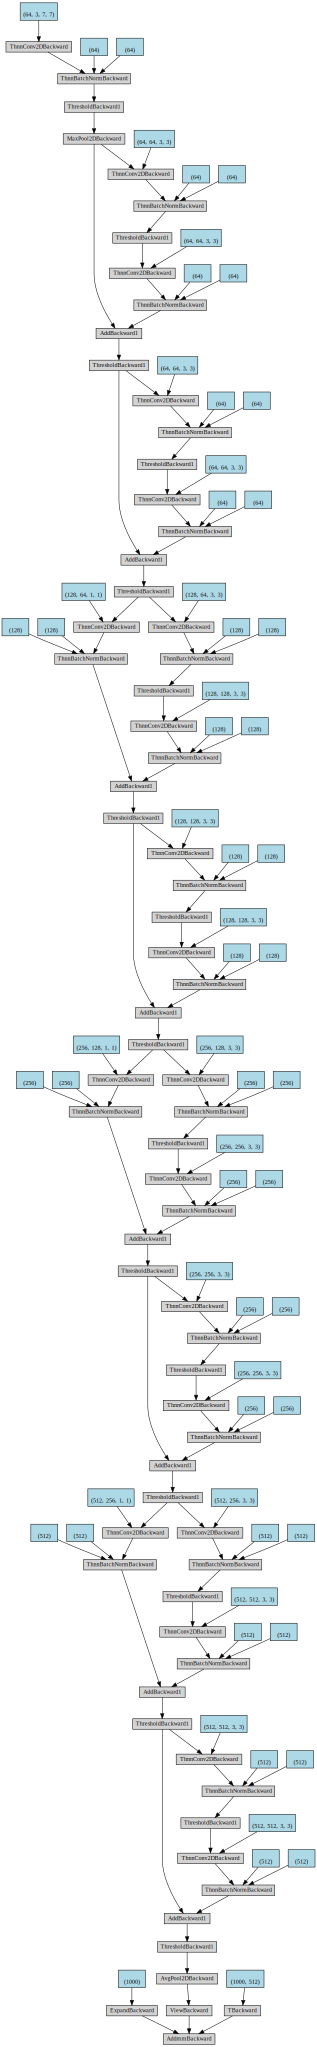

In [6]:
#own_model = own_vgg(90)
inputs = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
#vgg16_bn = models.vgg16_bn()
#print(own_model)
y = resnet18(Variable(inputs))

print(y.shape)
g = make_dot(y)
g

In [30]:
#print(resnet18)
print(own_model)

own_vgg(
  (features): Sequential(
    (0): Conv2d(90, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (8): ReLU(inplace)
      (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14)

In [18]:
device = torch.cuda.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

In [19]:
if torch.cuda.is_available():
    print('yes')

yes


In [35]:
import numpy as np

In [46]:
def Downsample (inplanes, outplanes, stride=2):
    downsample = nn.Sequential(
                nn.Conv2d(inplanes, outplanes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outplanes),
    )
    return downsample

class OwnResNetBlock(nn.Module):

    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(OwnResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = downsample


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class OwnResNetLikeModel(nn.Module):  

    def __init__(self, square_size, no_poses, in_planes, num_classes=3):  
        super(OwnResNetLikeModel, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.layer1 = OwnResNetBlock(64,64,stride=2,downsample=Downsample(64,64))
        self.layer2 = OwnResNetBlock(64,128,stride=2,downsample=Downsample(64,128))
        
        last_filter_size = 128
        downsampling_factor =4
        self.no_poses = np.int(no_poses)
        self.input_size_fc = np.int(((square_size/downsampling_factor)**2) * last_filter_size + no_poses)        
        self.fc1 = nn.Linear(self.input_size_fc, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512,3)
        
        self.Dropout = nn.Dropout(p=0.5)

    def forward(self, x, keypoints):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        
        #print(x.shape)
        x = x.view(-1, self.input_size_fc - self.no_poses)
        #print(x.shape)
        x = torch.cat((x,keypoints),dim=1)
        print(x.shape)
        x = self.fc1(x)
        x = self.Dropout(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.Dropout(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        
        return x

    #def _make_layer(self,block,planes):
    #    layers=[]
    #    layers.append(block(inplanes, planes, stride, downsample))
    #    return nn.Sequential(*layers)



In [47]:
test = OwnResNetLikeModel(40,60,90)
print(test)
vgg16 = models.vgg16_bn()
print (vgg16)

OwnResNetLikeModel(
  (conv1): Conv2d(90, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): OwnResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (layer2): OwnResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=

<class 'torch.FloatTensor'>
<class 'torch.autograd.variable.Variable'>
torch.Size([1, 12860])
torch.Size([1, 3])


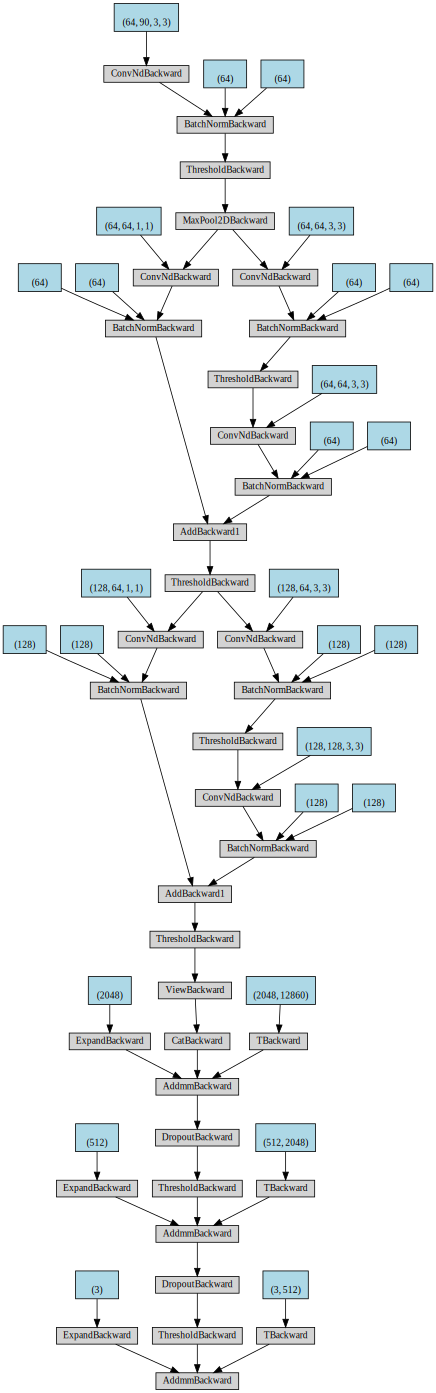

In [49]:
inputs = torch.randn(1,90,40,40)
keypoints = torch.randn(1,60)
print(type(inputs))
print(type(Variable(inputs)))
#resnet18 = models.resnet18()
#vgg16_bn = models.vgg16_bn()
#print(own_model)
y = test(Variable(inputs),Variable(keypoints))

print(y.shape)
g = make_dot(y)
g